In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35183")
client

<Client: 'tcp://127.0.0.1:35183' processes=8 threads=40, memory=157.36 GiB>

In [14]:
import numpy as np
import xarray as xr
import xrft
import xwavelet
from scipy.interpolate import griddata
import os.path as op
import scipy.signal as sps
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset

import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
ddir = '/tank/groups/climode/qjamet/RUNS/ORAR/reruns2/'
chaos = '/tank/chaocean/qjamet/RUNS/ORAR/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
spec = '/tank/spectre/tuchida/chaocean/RUNS/orar/'
# savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
savedir = '/tank/spectre/tuchida/NA-wavelets/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
sreg = ['A','B','C','D','E','F']
ntheta = 36
xo = 50e3

years = np.arange(1967,1968,dtype=int)
dnf = 2160; nfile = 73
ntimes = np.arange(1419120,1574640+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0

fiveD = 5*86400.
ctime = np.arange('1967-01-03', '1968-01-01', dtype='datetime64[D]')[::5]
csec = np.arange(0,len(ctime)*fiveD,fiveD)
ctime

array(['1967-01-03', '1967-01-08', '1967-01-13', '1967-01-18',
       '1967-01-23', '1967-01-28', '1967-02-02', '1967-02-07',
       '1967-02-12', '1967-02-17', '1967-02-22', '1967-02-27',
       '1967-03-04', '1967-03-09', '1967-03-14', '1967-03-19',
       '1967-03-24', '1967-03-29', '1967-04-03', '1967-04-08',
       '1967-04-13', '1967-04-18', '1967-04-23', '1967-04-28',
       '1967-05-03', '1967-05-08', '1967-05-13', '1967-05-18',
       '1967-05-23', '1967-05-28', '1967-06-02', '1967-06-07',
       '1967-06-12', '1967-06-17', '1967-06-22', '1967-06-27',
       '1967-07-02', '1967-07-07', '1967-07-12', '1967-07-17',
       '1967-07-22', '1967-07-27', '1967-08-01', '1967-08-06',
       '1967-08-11', '1967-08-16', '1967-08-21', '1967-08-26',
       '1967-08-31', '1967-09-05', '1967-09-10', '1967-09-15',
       '1967-09-20', '1967-09-25', '1967-09-30', '1967-10-05',
       '1967-10-10', '1967-10-15', '1967-10-20', '1967-10-25',
       '1967-10-30', '1967-11-04', '1967-11-09', '1967-

In [ ]:
# reg = 3
dg = 1
nmembs = np.arange(100,148)


for reg in range(1,len(xs)):
    
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          # iters=iiter, 
                         ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                               YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                               XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                               XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                              ).isel(Z=18)
    dsb = dsb.drop('time')
    dsb.coords['time'] = csec
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 # iters=iiter, 
                                ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                      YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                      XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                      XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                     ).isel(Z=18)
        else:
            ds = xr.concat([ds, 
                            open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                    % (nmemb)), 
                                            grid_dir=gdir,
                                            prefix=['snap_diagOcn'], delta_t=2e2,
                                            # iters=iiter, 
                                           ).sel(YC=slice(ys[reg]-5-dg/12,
                                                          ys[reg]+5+dg/12),
                                                 YG=slice(ys[reg]-5-dg/12,
                                                          ys[reg]+5+dg/12),
                                                 XC=slice(xs[reg]-5-dg/12,
                                                          xs[reg]+5+dg/12),
                                                 XG=slice(xs[reg]-5-dg/12,
                                                          xs[reg]+5+dg/12)
                                                ).isel(Z=18)
                           ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
    ds.coords['nmemb'] = ('nmemb',nmembs)
    ds = ds.drop('time')
    ds.coords['time'] = csec
    if reg == 0:
        print(ds)
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
        
    grid = Grid(ds, periodic=[],
                coords={'Y': {'center': 'YC', 'left': 'YG'},
                        'X': {'center': 'XC', 'left': 'XG'}}
               )
    
    xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                    ).isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                    ).isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
    ny, nx = xT.shape
    xT = xT - xT.isel(XC=nx//2)
    # (xT - xT.isel(YC=-1,XC=0)).plot()
    # plt.show()
    xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()
    
    up = ds.UVEL - dsb.UVEL
    vp = ds.VVEL - dsb.VVEL

    u = grid.interp(up,'X',boundary='extend'
                   ).where(ds.maskC!=0.
                          ).reset_coords(drop=True
                                        ).isel(YC=slice(dg,-dg),
                                               XC=slice(dg,-dg)
                                              )
    v = grid.interp(vp,'Y',boundary='extend'
                   ).where(ds.maskC!=0.
                          ).reset_coords(drop=True
                                        ).isel(YC=slice(dg,-dg),
                                               XC=slice(dg,-dg)
                                              )
    
    print(ds.dxC.mean(), ds.dyC.mean())
    dx = ds.dxC.min().values
    dy = ds.dyC.min().values
    N = u.isel(nmemb=0,time=0).shape

    uterp = xr.DataArray(np.zeros_like(u), dims=u.dims,
                         coords={'nmemb':nmembs,
                                 'time':up.time,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        ).chunk({'nmemb':1,'time':1})
    vterp = xr.DataArray(np.zeros_like(v), dims=v.dims,
                         coords={'nmemb':nmembs,
                                 'time':vp.time,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        ).chunk({'nmemb':1,'time':1})
    Aterp = xr.DataArray(np.zeros_like(ds.rA.isel(YC=slice(dg,-dg),XC=slice(dg,-dg))), 
                         dims=ds.rA.dims,
                         coords={'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    
    xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]
    Aterp[:] = griddata((xT, yT), 
                        (ds.rA.isel(YC=slice(dg,-dg),
                                    XC=slice(dg,-dg))).values.flatten(),
                        (xxx, yyy) 
               ).T
    for nn in range(len(nmembs)):
        for tt in range(len(ds.time)):

            uterp[dict(time=tt,nmemb=nn)] = griddata((xT, yT), 
                                                     (u * ds.rA.isel(YC=slice(dg,-dg),
                                                                     XC=slice(dg,-dg))
                                                     ).isel(nmemb=nn,time=tt
                                                           ).values.flatten(),
                                                     (xxx, yyy) 
                                            ).T 

            vterp[dict(time=tt,nmemb=nn)] = griddata((xT, yT), 
                                                     (v * ds.rA.isel(YC=slice(dg,-dg),
                                                                     XC=slice(dg,-dg))
                                                     ).isel(nmemb=nn,time=tt
                                                           ).values.flatten(),
                                                     (xxx, yyy) 
                                            ).T
    
    uterp = uterp / Aterp
    vterp = vterp / Aterp
    # ss = xr.DataArray(np.linspace(iso_psUf.freq_r[-1].data**-1,
    #                               iso_psUf.freq_r[0].data**-1,40)/xo,
#                       dims=['scale'], 
#                       coords={'scale':np.linspace(iso_psUf.freq_r[-1].data**-1,
#                                                   iso_psUf.freq_r[0].data**-1,40)/xo}
#     )
#     ssf = xr.DataArray(iso_psUf.freq_r.data**-1/xo, dims=['scale'], 
#                        coords={'scale':iso_psUf.freq_r.data**-1/xo}
#                       )
#     ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
#                      ssf.where(ssf<50e3/xo).dropna('scale')
#                     ], 'scale')
#     print(len(ssf),len(ssh))
#     iso_psUw = xwavelet.wvlt_power_spectrum(
#                     uterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
#                     xo=xo, ntheta=ntheta
#     ) 
#     iso_psVw = xwavelet.wvlt_power_spectrum(
#                     vterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
#                     xo=xo, ntheta=ntheta
#     )
    
#     dsave = iso_psUw.to_dataset(name='U')
#     dsave['V'] = iso_psVw
#     dsave.to_zarr(op.join(savedir,'Z0452/Points/%s/%010d/isoDiags_TKE.zarr' 
#                           % (sreg[reg],iiter)), mode='w')
    
    dsw = xr.open_zarr(op.join(savedir,'Z0452/Points/%s/%010d/isoDiags_TKE.zarr' 
                               % (sreg[reg],ntimes[0,0]))
                      )
    ssh = dsw.scale / xo
    if reg == 0:
        print(ssh)
        
    iso_psUw = xwavelet.wvlt_power_spectrum(
                    uterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
                    xo=xo, ntheta=ntheta
    ) 
    iso_psVw = xwavelet.wvlt_power_spectrum(
                    vterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
                    xo=xo, ntheta=ntheta
    )
    iso_psUwf = xrft.power_spectrum(
                    iso_psUw.chunk({'time':-1,'scale':10}), dim='time', window='hann',
                    window_correction=True
    )
    iso_psVwf = xrft.power_spectrum(
                    iso_psVw.chunk({'time':-1,'scale':10}), dim='time', window='hann',
                    window_correction=True
    )
    if reg == 0:
        print(iso_psUwf)
    
    dsave = iso_psUwf.to_dataset(name='U')
    dsave['V'] = iso_psVwf
    dsave.to_zarr(op.join(savedir,'Z0452/Points/%s/Omega-K/isoDiags_EKE.zarr' 
                          % (sreg[reg])), mode='w')
    dsave.close()
    dsb.close()
    ds.close()
    del u, v, uterp, vterp
    print(reg)

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    Z        >f4 -452.4
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray> <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    Z        >f4 -452.4
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:296: FutureWarning: This function has been renamed and will disappear in the future. Please use `power_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:296: FutureWarning: This function has been renamed and will disappear in the future. Please use `power_spectrum` instead.
  warnings.warn(msg, FutureWarning)


1
<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    Z        >f4 -452.4
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray> <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    Z        >f4 -452.4
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>


## 1967-71

In [6]:
ctime = np.arange('1967-01-03', '1972-01-01', dtype='datetime64[D]')[::5]
csec = np.arange(0,len(ctime)*fiveD,fiveD, dtype=np.float64)
csec

array([0.00000e+00, 4.32000e+05, 8.64000e+05, 1.29600e+06, 1.72800e+06,
       2.16000e+06, 2.59200e+06, 3.02400e+06, 3.45600e+06, 3.88800e+06,
       4.32000e+06, 4.75200e+06, 5.18400e+06, 5.61600e+06, 6.04800e+06,
       6.48000e+06, 6.91200e+06, 7.34400e+06, 7.77600e+06, 8.20800e+06,
       8.64000e+06, 9.07200e+06, 9.50400e+06, 9.93600e+06, 1.03680e+07,
       1.08000e+07, 1.12320e+07, 1.16640e+07, 1.20960e+07, 1.25280e+07,
       1.29600e+07, 1.33920e+07, 1.38240e+07, 1.42560e+07, 1.46880e+07,
       1.51200e+07, 1.55520e+07, 1.59840e+07, 1.64160e+07, 1.68480e+07,
       1.72800e+07, 1.77120e+07, 1.81440e+07, 1.85760e+07, 1.90080e+07,
       1.94400e+07, 1.98720e+07, 2.03040e+07, 2.07360e+07, 2.11680e+07,
       2.16000e+07, 2.20320e+07, 2.24640e+07, 2.28960e+07, 2.33280e+07,
       2.37600e+07, 2.41920e+07, 2.46240e+07, 2.50560e+07, 2.54880e+07,
       2.59200e+07, 2.63520e+07, 2.67840e+07, 2.72160e+07, 2.76480e+07,
       2.80800e+07, 2.85120e+07, 2.89440e+07, 2.93760e+07, 2.980

In [ ]:
nmembs = np.concatenate((np.arange(24), np.arange(36,60)))
dg = 1


for reg in range(1):
    
    for nn in nmembs[24:]:

        # if nn == nmembs[0]:
        for yy in range(1967,1972):
            
            if nn < 36:
                fname = op.join(chaos,'memb%02d/run%4d/ocn/' % (nn,yy))
            else:
                fname = op.join(spec,'memb%02d/run%4d/ocn/' % (nn,yy))
                
            ds = open_mdsdataset(fname, 
                                 grid_dir=gdir,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                 # iters=iiter, 
                                 # ignore_unknown_vars=True
                                ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                      YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                      XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                      XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                     ).isel(Z=18)

            if yy == 1967:
                U = ds.UVEL
                V = ds.VVEL
            else:
                U = xr.concat([U,ds.UVEL], 'time')
                V = xr.concat([V,ds.VVEL], 'time')

            ds.close()

        U = U.drop('time').reset_coords(drop=True)
        U = U.assign_coords({'time':ctime})
        V = V.drop('time').reset_coords(drop=True)
        V = V.assign_coords({'time':ctime})

        dsave = U.to_dataset(name='U')
        dsave['V'] = V
        dsave.to_zarr(op.join(savedir,'Z0452/Points/%s/memb%02d/1967-1971.zarr' 
                              % (sreg[reg],nn)), mode='w'
                     )
        dsave.close()
        print(nn)

In [7]:
iiters = np.arange(1421280, 2209680, dnf).reshape((5,nfile))

In [8]:
dg = 1
reg = 0
nmembs = np.concatenate((np.arange(24), np.arange(36,60)))
for nn in nmembs[:24]:
        
    if nn == 0:
        for yy in range(1967,1972):
            fname = op.join(chaos,'memb%02d/run%4d/ocn/' % (nn,1967))
            if yy == 1967:
                dsg = open_mdsdataset(fname, 
                                     grid_dir=gdir,
                                     prefix=['diag_ocnTave'], delta_t=2e2,
                                     iters=iiters[nn], 
                                         # ignore_unknown_vars=True
                                    ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                          YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                          XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                          XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                         ).isel(Z=18)
            else:
                dsg = xr.concat([dsg, 
                                 open_mdsdataset(fname, 
                                     grid_dir=gdir,
                                     prefix=['diag_ocnTave'], delta_t=2e2,
                                     iters=iiters[nn], 
                                         # ignore_unknown_vars=True
                                    ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                          YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                                          XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                                          XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                                         ).isel(Z=18)
                                ], 'time')
        if len(dsg.XG) > len(dsg.XC):
            dsg = dsg.isel(XG=slice(None,-1))
            
        grid = Grid(dsg, periodic=[],
                coords={'Y': {'center': 'YC', 'left': 'YG'},
                        'X': {'center': 'XC', 'left': 'XG'}}
               )
        
        ds = xr.open_zarr(op.join(savedir,'Z0452/Points/%s/memb%02d/1967-1971.zarr' 
                                  % (sreg[reg],nn))
                         )
    else:
        ds = xr.concat([ds, xr.open_zarr(op.join(savedir,
                                                 'Z0452/Points/%s/memb%02d/1967-1971.zarr' 
                                                 % (sreg[reg],nn))
                                        )
                       ], 'nmemb')
if len(ds.XG) > len(ds.XC):
    ds = ds.isel(XG=slice(None,-1))

ds = ds.drop('time').reset_coords(drop=True)
ds.coords['time'] = csec

up = grid.interp(ds.U - ds.U.mean('nmemb'),'X',boundary='extend'
                ).where(dsg.maskC!=0.
                        ).reset_coords(drop=True
                                    ).isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
vp = grid.interp(ds.V - ds.V.mean('nmemb'),'Y',boundary='extend'
                ).where(dsg.maskC!=0.
                        ).reset_coords(drop=True
                                    ).isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
up.coords['nmemb'] = nmembs[:24]
vp.coords['nmemb'] = nmembs[:24]

up, vp

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xmitgcm/

(<xarray.DataArray 'U' (nmemb: 24, time: 365, YC: 120, XC: 116)>
 dask.array<getitem, shape=(24, 365, 120, 116), dtype=float32, chunksize=(1, 1, 120, 116), chunktype=numpy.ndarray>
 Coordinates:
   * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
   * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
   * time     (time) timedelta64[ns] 3290 days 3295 days ... 3645 days 3650 days
   * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23,
 <xarray.DataArray 'V' (nmemb: 24, time: 365, YC: 120, XC: 116)>
 dask.array<getitem, shape=(24, 365, 120, 116), dtype=float32, chunksize=(1, 1, 120, 116), chunktype=numpy.ndarray>
 Coordinates:
   * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
   * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
   * time     (time) timedelta64[ns] 3290 days 3295 days ... 3645 days 3650 days
   * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7

In [9]:
xT = grid.cumsum(dsg.dxC,'X',boundary='extend'
                ).isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
yT = grid.cumsum(dsg.dyC,'Y',boundary='extend'
                ).isel(YC=slice(dg,-dg),XC=slice(dg,-dg))
ny, nx = xT.shape
xT = xT - xT.isel(XC=nx//2)

xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
yT = (yT - yT.isel(YC=0)).values.flatten()
    
    
print(dsg.dxC.mean(), dsg.dyC.mean())
dx = dsg.dxC.min().values
dy = dsg.dyC.min().values
N = up.isel(nmemb=0,time=0).shape


uterp = xr.DataArray(np.zeros_like(up), dims=up.dims,
                     coords={'nmemb':nmembs[:24],
                             'time':csec,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    ).chunk({'nmemb':1,'time':1})
vterp = xr.DataArray(np.zeros_like(vp), dims=vp.dims,
                     coords={'nmemb':nmembs[:24],
                             'time':csec,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    ).chunk({'nmemb':1,'time':1})
Aterp = xr.DataArray(np.zeros_like(dsg.rA.isel(YC=slice(dg,-dg),
                                               XC=slice(dg,-dg))), 
                     dims=dsg.rA.dims,
                     coords={'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
    
xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]
Aterp[:] = griddata((xT, yT), 
                    (dsg.rA.isel(YC=slice(dg,-dg),
                                 XC=slice(dg,-dg))).values.flatten(),
                    (xxx, yyy) 
                   ).T
for nn in range(len(nmembs[:24])):
    for tt in range(len(ds.time)):

        uterp[dict(time=tt,nmemb=nn)] = griddata((xT, yT), 
                                                 (up * dsg.rA.isel(YC=slice(dg,-dg),
                                                                   XC=slice(dg,-dg))
                                                 ).isel(nmemb=nn,time=tt
                                                       ).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 

        vterp[dict(time=tt,nmemb=nn)] = griddata((xT, yT), 
                                                 (vp * dsg.rA.isel(YC=slice(dg,-dg),
                                                                   XC=slice(dg,-dg))
                                                 ).isel(nmemb=nn,time=tt
                                                       ).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T
    
uterp = uterp / Aterp
vterp = vterp / Aterp

    
dsw = xr.open_zarr(op.join(savedir,'Z0452/Points/%s/%010d/isoDiags_TKE.zarr' 
                           % (sreg[reg],ntimes[0,0]))
                  )
ssh = dsw.scale / xo
        
iso_psUw = xwavelet.wvlt_power_spectrum(
                    uterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
                    xo=xo, ntheta=ntheta
    ) 
iso_psVw = xwavelet.wvlt_power_spectrum(
                    vterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
                    xo=xo, ntheta=ntheta
    )
iso_psUwf = xrft.power_spectrum(
                    iso_psUw.chunk({'time':-1,'scale':10}), dim='time', 
                    window='hann', window_correction=True
    )
iso_psVwf = xrft.power_spectrum(
                    iso_psVw.chunk({'time':-1,'scale':10}), dim='time', 
                    window='hann', window_correction=True
    )
    
dsave = iso_psUwf.to_dataset(name='U')
dsave['V'] = iso_psVwf
dsave.to_zarr(op.join(savedir,'Z0452/Points/%s/Omega-K/isoDiags_EKE_1967-1971.zarr' 
                      % (sreg[reg])), mode='w')
dsave.close()

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    Z        >f4 -452.4
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray> <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    Z        >f4 -452.4
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:296: FutureWarning: This function has been renamed and will disappear in the future. Please use `power_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:296: FutureWarning: This function has been renamed and will disappear in the future. Please use `power_spectrum` instead.
  warnings.warn(msg, FutureWarning)


In [10]:
ds = xr.open_dataset(op.join(savedir,'Z0452/Points/%s/Omega-K/isoDiags_EKE_1967-1971.zarr' 
                             % 'A'))
ds

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:    (nmemb: 24, freq_time: 365, angle: 18, scale: 47)
Coordinates:
  * angle      (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * freq_time  (freq_time) float64 -1.154e-06 -1.148e-06 ... 1.148e-06 1.154e-06
  * nmemb      (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
  * scale      (scale) float64 4.624e+05 4.511e+05 ... 2.109e+04 1.983e+04
Data variables:
    U          (nmemb, freq_time, angle, scale) float64 ...
    V          (nmemb, freq_time, angle, scale) float64 ...

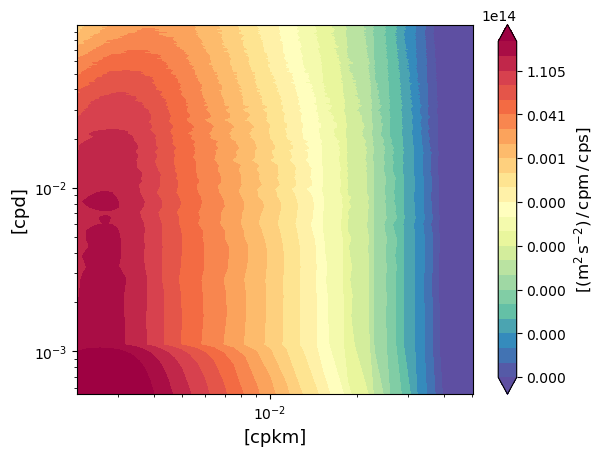

In [20]:
dag = np.pi/len(ds.angle)

fig, ax = plt.subplots()
im = ax.contourf(ds.scale**-1*1e3, 
                 ds.freq_time.where(ds.freq_time>0.).dropna('freq_time')*86400,
                 (ds.U + ds.V
                 ).where(ds.freq_time>0.
                        ).dropna('freq_time').mean('nmemb').sum('angle')*dag*2,
                 cmap='Spectral_r', 
                 norm=clr.LogNorm(),
                 levels=np.logspace(4,15,24),
                 extend='both'
                )
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r"[cpkm]", fontsize=13)
ax.set_ylabel(r"[cpd]",  fontsize=13)

cb = fig.colorbar(im, ax=ax)
cb.set_label(r"[(m$^2\,$s$^{-2})\,/\,$cpm$\,/\,$cps]", fontsize=12)